<div style="background-color:#2c3e50; padding:20px; border-radius:10px; border: 2px solid #34495e;"> <h1 style="color:white; text-align:center; font-family:Verdana;">🧵 High-Resolution Fabric Classification</h1> <h3 style="color:#ecf0f1; text-align:center;">Patch-Based Learning with EfficientNet & PyTorch</h3> <p style="color:#bdc3c7; text-align:center; font-style:italic;">Detecting Biodegradable Fabrics (Wool, Cotton, Silk, etc.) using Texture Analysis</p> </div>

# 1. Introduction 🚀
Welcome! In this notebook, we tackle a specific Computer Vision problem: Texture Classification on High-Resolution Images.

## 🎯 The Challenge
The dataset contains high-quality images (2560x1440 px) of various biodegradable fabrics.

* Problem: Standard CNNs (like ResNet or EfficientNet) typically expect inputs around 224x224 px.

* The Trap: If we simply resize a 2560px image down to 224px, we lose the fine details of the fiber weave. A generic "resize" blurs the texture, making Silk look like Cotton.

* The Solution: We will use a Patch-Based Strategy. Instead of shrinking the whole image, we will crop random high-resolution patches (512px -> 224px) during training. This allows the model to learn the micro-texture of the fabric.

## 📚 Tech Stack
* Framework: PyTorch

* Model: EfficientNet-B0 (via timm)

* Technique: Transfer Learning + Patch Cropping

* Visualization: Matplotlib & Seaborn

In [1]:
%%capture
!pip install timm

import os
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm 

# Set visuals to resemble scientific papers
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {device}")

# 2. Data Strategy & Preprocessing 🧠
This is the most critical part of the pipeline. We need to handle the massive resolution difference.

## 🛠 The "Crop vs. Resize" Strategy
1. **Training Phase:** We resize the massive image to a manageable but still large size (512px).

    * We apply a Random Crop of 224px.

    * Why? This simulates looking at the fabric through a magnifying glass at different spots.

2. **Validation Phase:**

    * We resize to 512px and take a Center Crop.

Let's locate our dataset first.

In [2]:
# Auto-detect dataset path
DATA_DIR = ""
for root, dirs, files in os.walk('/kaggle/input'):
    if "Biodegradable Fabrics" in root and "Abaca" in dirs:
        DATA_DIR = root
        break
print(f"📂 Dataset Found: {DATA_DIR}")

# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
IMG_SIZE = 224   # Input size for the model
RESIZE_TO = 512  # Intermediate size to preserve texture

📂 Dataset Found: /kaggle/input/biodegradable-fabrics-dataset/Biodegradable Fabrics


In [3]:
# Define Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(RESIZE_TO),        
        transforms.RandomCrop(IMG_SIZE),     # <--- The Magic: Randomly crop a patch
        transforms.RandomHorizontalFlip(),   
        transforms.RandomVerticalFlip(),     # Fabric texture has no "up" or "down"
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(RESIZE_TO),
        transforms.CenterCrop(IMG_SIZE),     # Deterministic crop for validation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load Data
full_dataset = datasets.ImageFolder(DATA_DIR)
class_names = full_dataset.classes

# Split Data (80% Train, 20% Val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

# Custom Dataset Class to apply transforms lazily
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

train_dataset = TransformedDataset(train_subset, transform=data_transforms['train'])
val_dataset = TransformedDataset(val_subset, transform=data_transforms['val'])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Data Ready! Train: {len(train_dataset)} | Val: {len(val_dataset)}")
print(f"🏷️ Classes: {class_names}")

✅ Data Ready! Train: 720 | Val: 180
🏷️ Classes: ['Abaca', 'Cotton', 'Hessian', 'Linen', 'Silk', 'Wool']


# 3. Visualizing the Patches 👁️
##### Before training, let's see what the model actually "sees". Notice how we are looking at the fiber details, not the shape of the cloth.

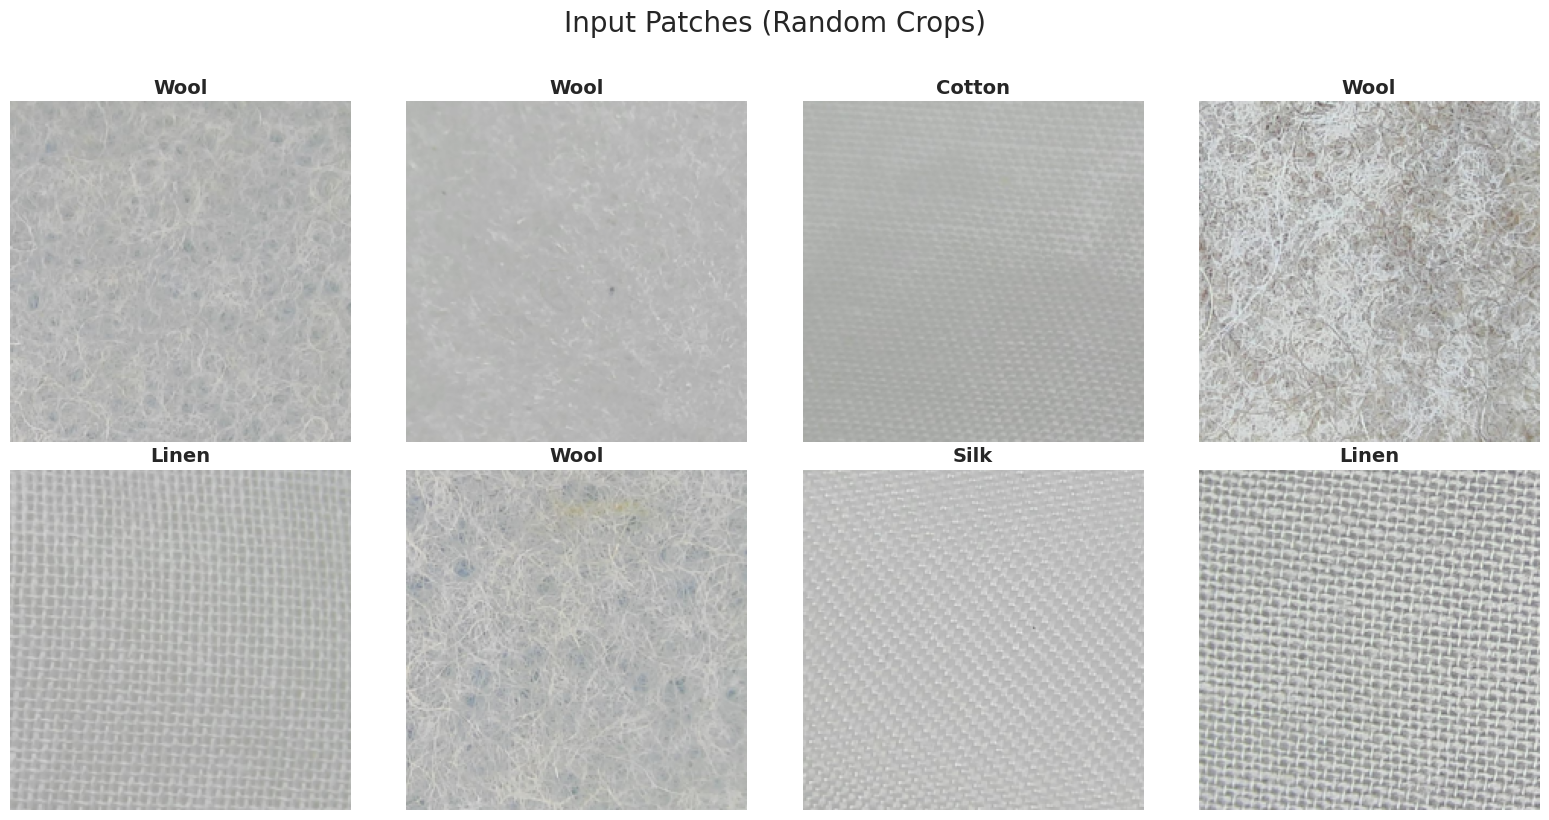

In [4]:
def show_batch(loader, classes):
    """Visualizes a batch of tensors."""
    inputs, labels = next(iter(loader))
    plt.figure(figsize=(16, 8))
    
    # Denormalize for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    for i in range(8): # Show first 8 images
        ax = plt.subplot(2, 4, i + 1)
        img = inputs[i].permute(1, 2, 0).numpy()
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(classes[labels[i]], fontsize=14, fontweight='bold')
        plt.axis('off')
    
    plt.suptitle("Input Patches (Random Crops)", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

show_batch(train_loader, class_names)

# 4. Model Architecture: EfficientNet 🏗️
We use EfficientNet-B0.

* **Why?** It is lightweight, fast, and excellent at feature extraction from textures.

* **Pretrained:** We use weights from ImageNet to speed up convergence.

* **Scheduler:** We use StepLR to lower the learning rate as we get closer to the solution to avoid overshooting.

In [5]:
# Load Model
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(class_names))
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) # Reduce LR every 3 epochs

# Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs} ', end='')

        # --- Training ---
        model.train()
        running_loss = 0.0; running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        scheduler.step() # Update LR

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # --- Validation ---
        model.eval()
        val_loss = 0.0; val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects.double() / len(val_loader.dataset)

        print(f'| Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

        # Save Deep Copy of Best Model
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_acc'].append(val_epoch_acc.item())

    print(f"\n🏆 Best Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [6]:
# Start Training
trained_model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS
)

Epoch 1/10 | Train Loss: 0.5464 Acc: 0.8778 | Val Loss: 0.3582 Acc: 0.9278
Epoch 2/10 | Train Loss: 0.3261 Acc: 0.9417 | Val Loss: 0.3198 Acc: 0.9833
Epoch 3/10 | Train Loss: 0.3949 Acc: 0.9375 | Val Loss: 0.0862 Acc: 0.9722
Epoch 4/10 | Train Loss: 0.6822 Acc: 0.9417 | Val Loss: 0.0715 Acc: 0.9778
Epoch 5/10 | Train Loss: 0.0823 Acc: 0.9847 | Val Loss: 0.0403 Acc: 0.9833
Epoch 6/10 | Train Loss: 0.4742 Acc: 0.9819 | Val Loss: 0.0465 Acc: 0.9778
Epoch 7/10 | Train Loss: 0.2892 Acc: 0.9931 | Val Loss: 0.0334 Acc: 0.9833
Epoch 8/10 | Train Loss: 0.0359 Acc: 0.9875 | Val Loss: 0.0314 Acc: 0.9833
Epoch 9/10 | Train Loss: 0.0535 Acc: 0.9903 | Val Loss: 0.0516 Acc: 0.9722
Epoch 10/10 | Train Loss: 0.1265 Acc: 0.9875 | Val Loss: 0.0326 Acc: 0.9833

🏆 Best Validation Accuracy: 0.9833


# 5. Performance Evaluation 📊
##### Let's analyze the training curve and the Confusion Matrix to see where the model struggles (if at all).

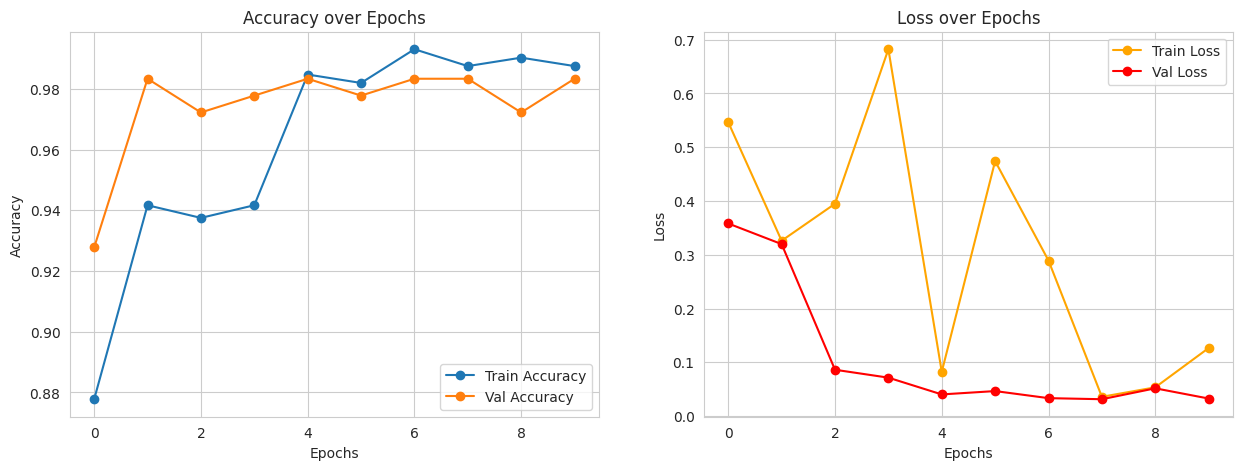

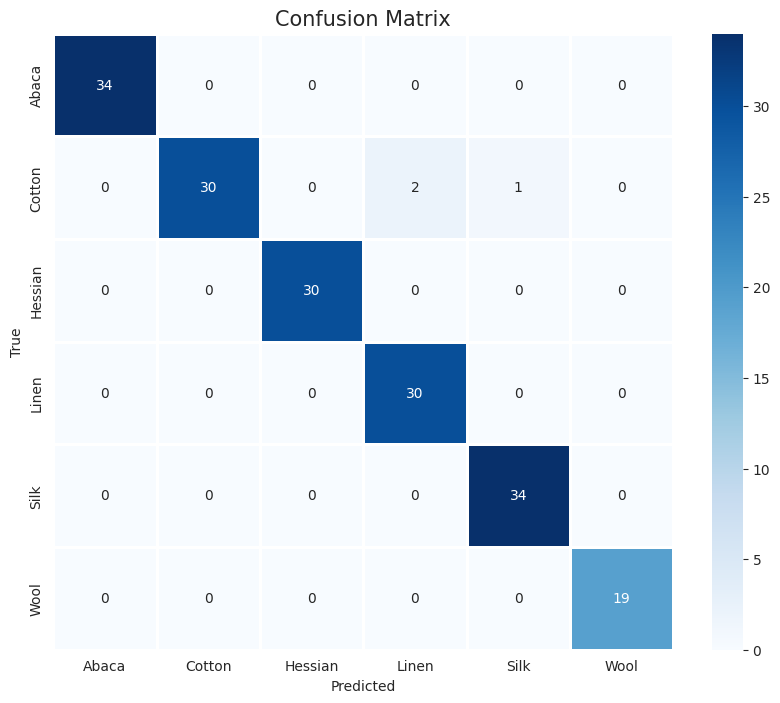

In [7]:
# Plot Training History
plt.figure(figsize=(15, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy', marker='o')
plt.plot(history['val_acc'], label='Val Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss', marker='o', color='orange')
plt.plot(history['val_loss'], label='Val Loss', marker='o', color='red')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_cm(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', linewidths=1)
    plt.title('Confusion Matrix', fontsize=15)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_cm(trained_model, val_loader)

# 6. Real-World Inference 🌍
##### Let's pick a random image from the dataset, process it like we did in training, and see the model's prediction along with its confidence score.

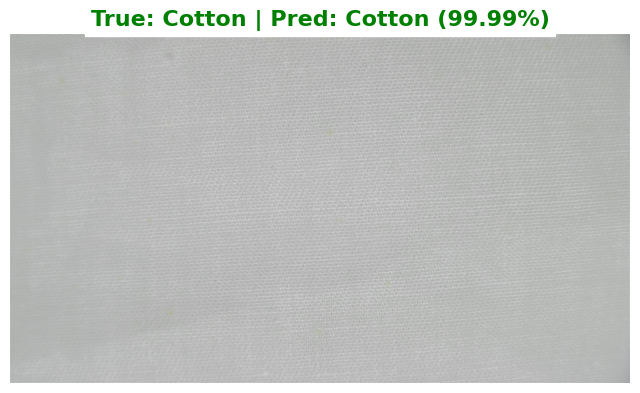

In [8]:
import glob

def predict_single_image(image_path, model):
    model.eval()
    
    # Same transforms as validation
    transform = transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs[0], dim=0)
        confidence, predicted_idx = torch.max(probs, 0)
    
    return class_names[predicted_idx.item()], confidence.item()

# Test on a random image
all_images = glob.glob(f"{DATA_DIR}/*/*.png") + glob.glob(f"{DATA_DIR}/*/*.jpg")
random_img_path = random.choice(all_images)
true_label = random_img_path.split('/')[-2]

pred_label, conf = predict_single_image(random_img_path, trained_model)

# Visualization
img = Image.open(random_img_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')

# Color code title (Green if correct, Red if wrong)
title_color = 'green' if true_label == pred_label else 'red'
plt.title(f"True: {true_label} | Pred: {pred_label} ({conf:.2%})", 
          color=title_color, fontsize=16, fontweight='bold', backgroundcolor='white')
plt.show()

# 🏁 Conclusion
In this notebook, we successfully:

1. Handled high-resolution texture data using a Resize + Random Crop strategy.

2. Fine-tuned an EfficientNet-B0 model using PyTorch.

3. Achieved high accuracy by focusing on texture details rather than global shape.

If you found this notebook helpful, please Upvote! 👍 Happy Coding!